In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
!pip install tensorflow==2.0.0-beta0

     |████████████████████████████████| 87.9MB 46.0MB/s 
     |████████████████████████████████| 501kB 30.1MB/s 
     |████████████████████████████████| 3.1MB 47.8MB/s 
     |████████████████████████████████| 61kB 25.2MB/s 
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import MinMaxScaler

In [0]:
tf.version

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>

# PREPROCESSING

Read IBM stock OHLC ( open, high, low, close) and S&P 500 bid/ask data. data into pandas dataframe.

In [0]:
os.chdir('My Drive/datasets')
df_ibm = pd.read_csv('IBM_adjusted.txt', sep=",", header=None)
df_sp = pd.read_csv('IVE_bidask1min.txt', sep=",", header=None)
df_ibm.columns = ["Date", "Time", "Open", "High", "Low", "Close", "Volume"]
df_sp.columns = ["Date","Time","BidOpen","BidHigh","BidLow",
                 "BidClose","AskOpen","AskHigh","AskLow","AskClose"]
df_sp.head()

,Date,Time,BidOpen,BidHigh,BidLow,BidClose,AskOpen,AskHigh,AskLow,AskClose
0,09/28/2009,09:30,40.86,40.86,40.86,40.86,40.93,40.93,40.93,40.93
1,09/28/2009,09:31,40.90,40.90,40.88,40.89,40.91,40.91,40.90,40.91
2,09/28/2009,09:32,40.91,40.95,40.91,40.95,40.93,40.97,40.93,40.97
3,09/28/2009,09:33,40.94,40.94,40.94,40.94,40.95,40.97,40.95,40.96
4,09/28/2009,09:34,40.94,40.94,40.93,40.93,40.96,40.96,40.94,40.94


Transform Bid/Ask data to OHLC format by taking average of both low and high counterparts.

In [0]:
df_sp['S_Open'] = (df_sp['BidOpen']+df_sp['AskOpen'])/2.0
df_sp['S_Low'] = (df_sp['BidLow']+df_sp['AskLow'])/2.0
df_sp['S_High'] = (df_sp['BidHigh']+df_sp['AskHigh'])/2.0
df_sp['S_Close'] = (df_sp['BidClose']+df_sp['AskClose'])/2.0
df_sp = df_sp.drop(columns=['BidOpen', 'BidHigh', 'BidLow', 'BidClose', 'AskOpen', 'AskHigh', 'AskLow', 'AskClose'])
df_sp.head()

,Date,Time,S_Open,S_Low,S_High,S_Close
0,09/28/2009,09:30,40.895,40.895,40.895,40.895
1,09/28/2009,09:31,40.905,40.890,40.905,40.900
2,09/28/2009,09:32,40.920,40.920,40.960,40.960
3,09/28/2009,09:33,40.945,40.945,40.955,40.950
4,09/28/2009,09:34,40.950,40.935,40.950,40.935


**Create training data**

In [0]:
df_spi = df_sp.iloc[603800:-1, :].copy()
df_spi.shape

(188248, 6)

In [0]:
df = df_ibm.iloc[2040437:-1, :].copy()
df.shape

(188200, 7)

Combining Date and time columns to single DateTime column and in datetime format.

In [0]:
df['Date'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df_spi['Date'] = pd.to_datetime(df_spi['Date'] + ' ' + df_spi['Time'])

Set date as index of both dataframes and drop TIme as its of no use now.

In [0]:
df_spi = df_spi.set_index('Date')
df = df.set_index('Date')

In [0]:
df_spi = df_spi.drop(columns=['Time'])
df = df.drop(columns=['Time'])

Concatenate the two dataframes with Datetime as index.

In [0]:
df_concat = pd.concat([df, df_spi], axis=1, join_axes=[df.index])

In [0]:
df_concat.tail()

,Open,High,Low,Close,Volume,S_Open,S_Low,S_High,S_Close
Date,,,,,,,,,
2019-06-03 18:20:00,128.72,128.72,128.72,128.72,135,NaN,NaN,NaN,NaN
2019-06-04 07:15:00,128.88,128.88,128.51,128.73,600,NaN,NaN,NaN,NaN
2019-06-04 08:00:00,128.90,129.23,128.90,129.23,900,NaN,NaN,NaN,NaN
2019-06-04 08:25:00,129.24,129.25,129.10,129.10,414,NaN,NaN,NaN,NaN
2019-06-04 09:00:00,129.18,129.18,128.93,128.93,108,NaN,NaN,NaN,NaN


In [0]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 188200 entries, 2017-08-22 11:15:00 to 2019-06-04 09:00:00
Data columns (total 9 columns):
Open       188200 non-null float64
High       188200 non-null float64
Low        188200 non-null float64
Close      188200 non-null float64
Volume     188200 non-null int64
S_Open     152360 non-null float64
S_Low      152360 non-null float64
S_High     152360 non-null float64
S_Close    152360 non-null float64
dtypes: float64(8), int64(1)
memory usage: 14.4 MB


In [0]:
df_concat = df_concat.dropna()
df_concat.shape

(152360, 9)

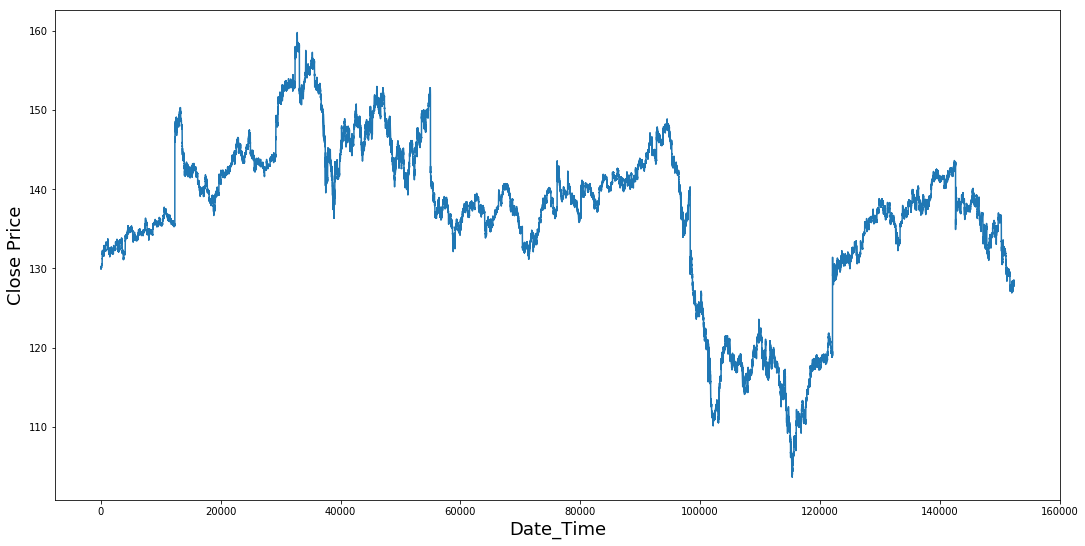

In [0]:
plt.figure(figsize = (18,9))
plt.plot(range(df_concat.shape[0]),(df_concat['Close']))
#plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date_Time',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

In [0]:
# how long preceding sequence to consider for prediction
SEQ_LEN = 60            

# How far into the future we are making prediction(10 min in this case)
FUTURE_PERIOD = 10

RATIO_TO_PREDICT = "Close"


In [0]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

Split the data as last 10 % for testing, the next last 20% for validation and remaining 70% for training the model. 

In [0]:
times = sorted(df_concat.index.values)  # get the times
last_10 = sorted(df_concat.index.values)[-int(0.1*len(times))] 
last_20 = sorted(df_concat.index.values)[-int(0.2*len(times))]

test_df = df_concat[(df_concat.index >= last_10)]
validation_df = df_concat[(df_concat.index >= last_20) & (df_concat.index < last_10)]  
train_df = df_concat[(df_concat.index < last_20)] 

In [0]:
from collections import deque
import numpy as np
import random

In [0]:
#dfX_train = train_df.drop(columns=["target"])
#dfX_test = test_df.drop(columns=["target"])
#dfX_valid = validation_df.drop(columns=["target"])

train_ = train_df.values
valid_ = validation_df.values
test_ = test_df.values

In [0]:
print("train shape {0}".format(train_.shape))
print("valid shape {0}".format(valid_.shape))
print("test shape {0}".format(test_.shape))

train shape (121888, 9)
valid shape (15236, 9)
test shape (15236, 9)


In [0]:
#y_train = train_df["target"].values
#y_test = test_df["target"].values
#y_valid = validation_df["target"].values

Initialise scaler to scale the values i.e. normalize the feature vectors. Then fit the scaler on training data and eventually transform the data between 0 and 1.
This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.



In [0]:
scaler = MinMaxScaler()
scale_close = MinMaxScaler()

In [0]:
x = train_[:,3].copy()
scale_close.fit(x.reshape(-1, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
scaler.fit(train_)

train_ = scaler.transform(train_)

valid_ = scaler.transform(valid_)
test_ = scaler.transform(test_)

Perform Exponential moving average. The exponential moving average (EMA) is a weighted moving average (WMA) that gives more weighting, or importance, to recent price data.

In [0]:
# Now perform exponential moving average smoothing for smooth curve of data
EMA = 0.0
gamma = 0.1
for ti in range(121888):
    EMA = gamma*train_[ti] + (1-gamma)*EMA
    train_[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_,valid_, test_],axis=0)

Method to split the given numpy array into sequences of previous timesteps data. I have taken 60 timesteps of historical data as 1 training example.

In [0]:
def split_data(data):
    X = []
    Y = []
    for i in range(SEQ_LEN, len(data)-FUTURE_PERIOD+1):
        X.append(data[i-SEQ_LEN:i])
        Y.append(data[i+(FUTURE_PERIOD-1), 3])
    return np.array(X), np.array(Y)

In [0]:
#def split_data_categorical(X_data, y_data):
#    X = []
#    Y = []
#    for i in range(SEQ_LEN, len(X_data)-FUTURE_PERIOD+1):
#       X.append(X_data[i-SEQ_LEN:i])
#        Y.append(y_data[i+(FUTURE_PERIOD-1),])
#    return np.array(X), np.array(Y)

In [0]:
X_train, y_train = split_data(train_)
X_test, y_test = split_data(test_)
X_valid, y_valid = split_data(valid_)

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 9))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 9))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 9))

In [0]:
y_train.shape

(121819,)

In [0]:
print("train shape {0}".format(X_train.shape))
print("valid shape {0}".format(X_valid.shape))
print("test shape {0}".format(X_test.shape))

train shape (121819, 60, 9)
valid shape (15167, 60, 9)
test shape (15167, 60, 9)


In [0]:
X_train_2, y_train_2 = split_data(train_)
X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 9))

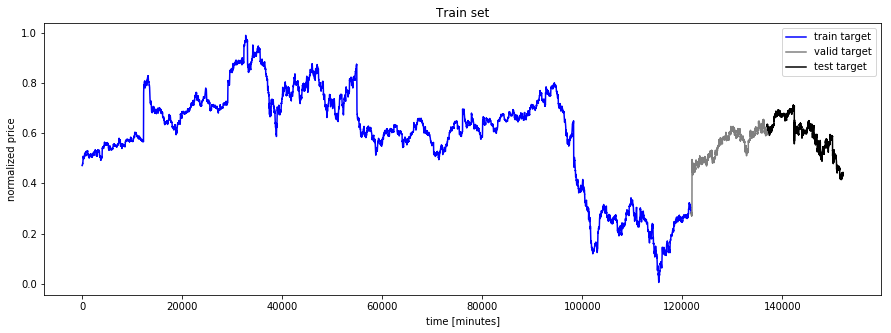

In [0]:
## show predictions
plt.figure(figsize=(15, 5))

plt.plot(np.arange(y_train_2.shape[0]), y_train_2, color='blue', label='train target')

plt.plot(np.arange(y_train_2.shape[0], y_train_2.shape[0]+y_valid.shape[0]), y_valid,
         color='gray', label='valid target')

plt.plot(np.arange(y_train_2.shape[0]+y_valid.shape[0],
                   y_train_2.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test, color='black', label='test target')


plt.title('Train set')
plt.xlabel('time [minutes]')
plt.ylabel('normalized price')
plt.legend(loc='best');

# TRANSFORMER

In [0]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [0]:
EPOCHS = 60
BATCH_SIZE = 256

import time

In [0]:
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Layer

Normalize the activations of the previous layer for each given example in a batch independently, rather than across a batch like Batch Normalization. i.e. applies a transformation that maintains the mean activation within each example close to 0 and the activation standard deviation close to 1.

In [0]:
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape


The scaled dot-product attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$
As the softmax normalization is done on the key, its values decide the amount of importance given to the query.


The output represents the multiplication of the attention weights and the value vector. This ensures that the parts we want to focus on are kept as is and the irrelevant parts are flushed out. The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax.


For example, consider that query and key have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of dk. Hence, square root of dk is used for scaling (and not any other number) because the matmul of query and key should have a mean of 0 and variance of 1, so that we get a gentler softmax.





In [0]:
class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

Multi-head attention consists of four parts:


*   Linear layers and split into heads.
*   Scaled dot-product attention.
*   Concatenation of heads.
*   Final linear layer


Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads.

The scaled_dot_product_attention defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step. The attention output for each head is then concatenated (using tf.transpose, and tf.reshape) and put through a final Dense layer.

Instead of one single attention head, query, key, and value are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.



*I have implemented two modes of multi head attention one has simple Dense layers the other one has Time Distributed Dense Layers.*

In [0]:
class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

**Encoder Layer**

Each encoder layer consists of sublayers:

    1. Multi-head attention (with padding mask)
    2. dense layers followed by dropout
    
Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis.

In [0]:
class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

    
class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn
    
    
def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

**Custom learning rate**


Use the Adam optimizer with a custom learning rate scheduler according to the formula in the paper.

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [0]:
class CustomeLearningSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomeLearningSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        param_1 = tf.math.rsqrt(step)
        param_2 = step * (self.warmup_steps**(-1.5))
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(param_1, param_2)

Text(0.5, 0, 'Train Step')

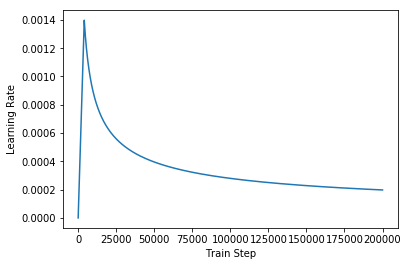

In [0]:
sample_learning_rate = CustomeLearningSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")


In [0]:
D_MODEL=300

lr = CustomeLearningSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

In [0]:
def build_model():
    inp = Input(shape = (SEQ_LEN, 9))

    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
    #for i in range(2):
    x, self_attn = EncoderLayer(
            d_model=D_MODEL,
            d_inner_hid=512, 
            n_head=4, 
            d_k=64,
            d_v=64, 
            dropout=0.2)(x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(128, activation="relu")(conc)
    x = Dense(1, activation="sigmoid")(conc)      

    model = Model(inputs = inp, outputs = x)
    model.compile(
        loss = "mean_squared_error",  
        optimizer = optimizer)
    
    return model

In [0]:
multi_head = build_model()
multi_head.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 9)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 60, 256)      141312      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 60, 128)      164352      bidirectional[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 60, 256)      32768       bidirectional_1[0][0]            
______________________________________________________________________________________________

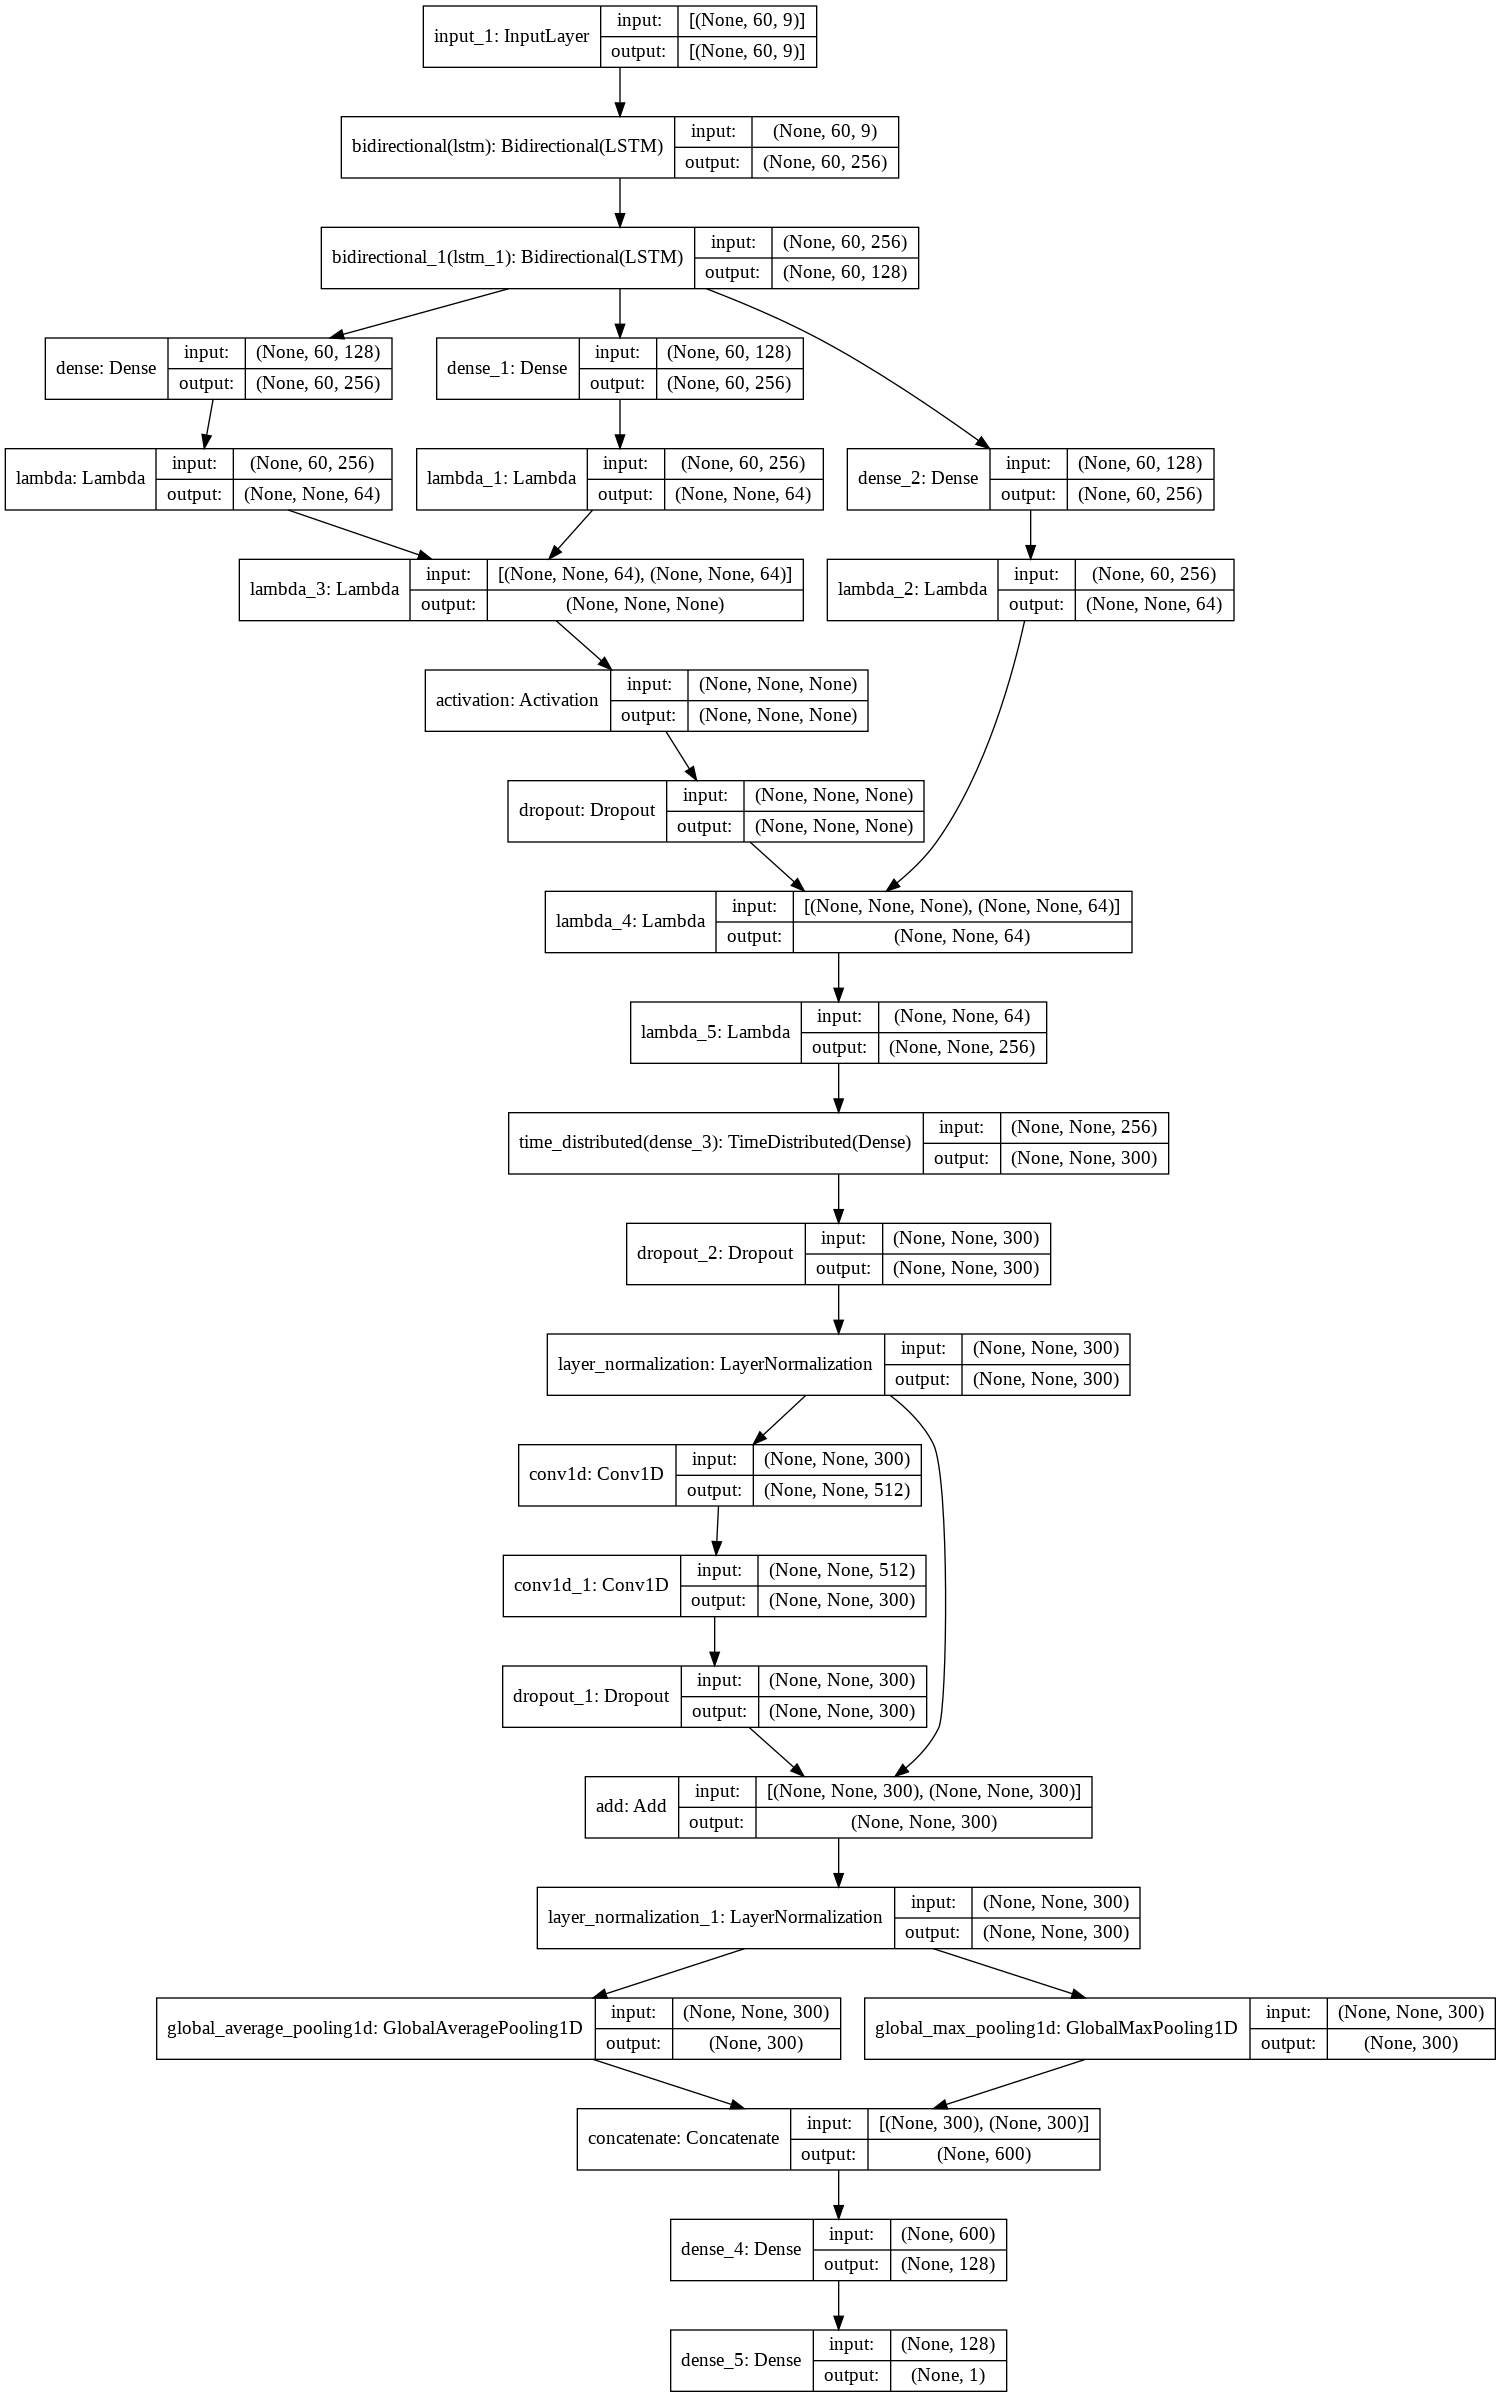

In [0]:
tf.keras.utils.plot_model(multi_head, 
                          to_file="multi_head_net.png", 
                          show_shapes=True)

# TRAINING

In [0]:
callback = EarlyStopping(monitor='val_loss',
                         patience=3,
                         restore_best_weights=True)

In [0]:
history = multi_head.fit(x=X_train, 
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_valid, y_valid), 
                         callbacks=[callback])

Train on 121819 samples, validate on 15167 samples
Epoch 1/60
121819/121819 [==============================] - 1296s 11ms/sample - loss: 0.0036 - val_loss: 0.0060
Epoch 2/60
121819/121819 [==============================] - 1244s 10ms/sample - loss: 3.6834e-04 - val_loss: 2.6506e-04
Epoch 3/60
121819/121819 [==============================] - 1307s 11ms/sample - loss: 2.8242e-04 - val_loss: 0.0011
Epoch 4/60
121819/121819 [==============================] - 1361s 11ms/sample - loss: 2.2475e-04 - val_loss: 0.0018
Epoch 5/60
121819/121819 [==============================] - 1372s 11ms/sample - loss: 1.9788e-04 - val_loss: 0.0039


In [0]:
#multi_head.save_weights('./checkpoints/final_checkpoint_1')

In [0]:
 model.load_weights('./checkpoints/final_checkpoint_1')

# TESTING

In [0]:
predicted_stock_price_multi_head = multi_head.predict(X_test)
#predicted_stock_price_multi_head = scaler.inverse_transform(predicted_stock_price_multi_head)


predicted_stock_price_multi_head.shape

(15167, 1)

Stacking arrays in sequence vertically (row wise).

In [0]:
predicted_stock_price = np.vstack((np.full((60,1), np.nan), predicted_stock_price_multi_head))

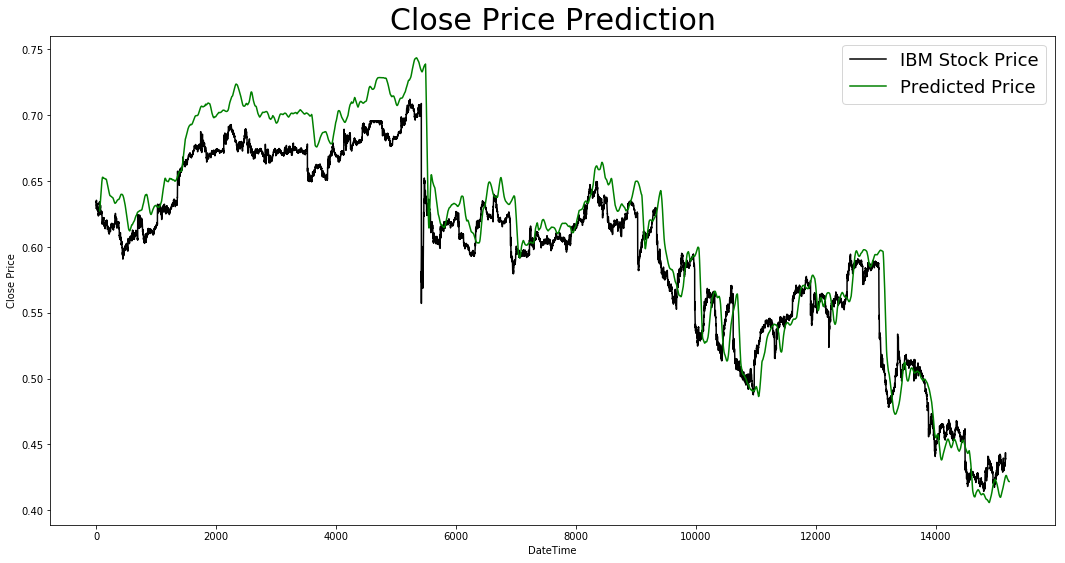

In [0]:
plt.plot(y_test, color = 'black', label = 'IBM Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Price')
plt.title('Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()